In [1]:
import numpy as np
import re
from collections import defaultdict
import networkx as nx
from tqdm import tqdm
from node2vec import Node2Vec
import pickle
import multiprocessing
from gensim.models import Word2Vec 

C:\Users\kolpa\Anaconda3\envs\p3.6-tensorflow1.13\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


# Read data

In [2]:
with open('data/data_ps.bodies.train', 'r', encoding="utf-8") as f:
    bodies = f.readlines()
with open('data/data_ps.declarations.train', 'r', encoding="utf-8") as f:
    declarations = f.readlines()
with open('data/data_ps.descriptions.train', 'r', encoding="latin1") as f:
    descriptions = f.readlines()

In [3]:
def is_capital_letter(c: str):
    return c.isalpha() and not c.islower()
    
def split_by_capital(s: str):
    ns = s[0].lower()
    prevCap = not s[0].islower()
    for i, c in enumerate(s[1:]):
        if is_capital_letter(c) and not prevCap:
            ns += '_'
            prevCap = True
        if c.islower() and prevCap:
            if len(ns) > 2:
                if is_capital_letter(s[i]) and is_capital_letter(s[i - 1]):
                    ns = ns[:-1] + '_' + ns[-1]
            prevCap = False
        ns += c.lower()
    return ns

def subtokenize(s: str):
    s = [split_by_capital(x) for x in re.split('_|\d', s) if x != '' ]  
    return '_'.join(s)
    
def extract_func_name(s: str):
    s = s.split(' DCNL ')[-1]
    s = re.split("\(|\s", s)
    if len(s) == 1:
        s = s[0]
    else:
        s = s[1]
    return subtokenize(s)

In [4]:
func_names = [extract_func_name(declaration) for declaration in declarations]

In [5]:
unq_func_names = sorted(list(set(func_names)))
r_func_names = defaultdict(lambda: None, {name:id for id, name in enumerate(unq_func_names)})

In [6]:
len(func_names), len(unq_func_names)

(109108, 75994)

# Build graph

In [7]:
G = nx.DiGraph()

In [8]:
def parse_body(body):
    tmp = [re.split('\(', var)[0] for var in re.split('\s|\.', body) if re.match('.*\(.*', var) is not None]
    tmp = list(filter(lambda x: x != '' and x != '=', tmp))
    return [extract_func_name(x) for x in tmp]

In [9]:
for body, name in tqdm(list(zip(bodies, func_names))):
    adjacent_names = parse_body(body)
    adjacent_names = [adj_name for adj_name in adjacent_names if r_func_names[adj_name] is not None]
    for adj_names in adjacent_names:
        G.add_edge(name, adj_names)

100%|████████████████████████████████████████████████████████████████████████| 109108/109108 [00:20<00:00, 5414.65it/s]


In [10]:
len(G.nodes), len(G.edges)

(70796, 326693)

# Find random walks by node2vec

In [28]:
Node2Vec(G).p

Computing transition probabilities: 0it [00:00, ?it/s]
Generating walks (CPU: 1): 100%|████████████████████████████████████████████████████| 10/10 [00:00<00:00, 10027.02it/s]


1

In [29]:
# Precompute probabilities and generate walks - **ON WINDOWS ONLY WORKS WITH workers=1**
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=80, workers=1)  # Use temp_folder for big graphs

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 80/80 [36:06<00:00, 27.70s/it]


In [30]:
with open('walks.n2v', 'wb') as f:
    pickle.dump(node2vec, f)

# Train Word2Vec on generated random walks

In [31]:
import logging  # Setting up the loggings to monitor gensim
from time import time  # To time our operations
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [32]:
model = Word2Vec(size = node2vec.dimensions, window=5, min_count=1, workers = multiprocessing.cpu_count() - 1, sg = 1)

In [34]:
model.build_vocab(node2vec.walks, progress_per=10000)

INFO - 01:39:25: collecting all words and their counts
INFO - 01:39:25: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 01:39:25: PROGRESS: at sentence #10000, processed 106510 words, keeping 13289 word types
INFO - 01:39:25: PROGRESS: at sentence #20000, processed 212096 words, keeping 23860 word types
INFO - 01:39:25: PROGRESS: at sentence #30000, processed 316123 words, keeping 33778 word types
INFO - 01:39:25: PROGRESS: at sentence #40000, processed 422288 words, keeping 43215 word types
INFO - 01:39:25: PROGRESS: at sentence #50000, processed 527638 words, keeping 52455 word types
INFO - 01:39:25: PROGRESS: at sentence #60000, processed 632947 words, keeping 61424 word types
INFO - 01:39:25: PROGRESS: at sentence #70000, processed 739730 words, keeping 70096 word types
INFO - 01:39:25: PROGRESS: at sentence #80000, processed 844368 words, keeping 70796 word types
INFO - 01:39:25: PROGRESS: at sentence #90000, processed 948367 words, keeping 70796 word type

INFO - 01:39:28: PROGRESS: at sentence #1650000, processed 17394551 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1660000, processed 17499827 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1670000, processed 17604901 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1680000, processed 17710036 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1690000, processed 17817432 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1700000, processed 17921879 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1710000, processed 18025673 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1720000, processed 18129399 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1730000, processed 18235559 words, keeping 70796 word types
INFO - 01:39:28: PROGRESS: at sentence #1740000, processed 18341965 words, keeping 70796 word types


INFO - 01:39:32: PROGRESS: at sentence #3270000, processed 34466109 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3280000, processed 34572207 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3290000, processed 34676335 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3300000, processed 34780853 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3310000, processed 34884343 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3320000, processed 34992489 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3330000, processed 35098125 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3340000, processed 35205664 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3350000, processed 35311281 words, keeping 70796 word types
INFO - 01:39:32: PROGRESS: at sentence #3360000, processed 35418275 words, keeping 70796 word types


INFO - 01:39:35: PROGRESS: at sentence #4890000, processed 51553128 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4900000, processed 51658431 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4910000, processed 51765134 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4920000, processed 51869189 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4930000, processed 51974006 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4940000, processed 52077737 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4950000, processed 52183543 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4960000, processed 52289405 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4970000, processed 52392536 words, keeping 70796 word types
INFO - 01:39:35: PROGRESS: at sentence #4980000, processed 52497183 words, keeping 70796 word types


In [35]:
t = time()

model.train(node2vec.walks, total_examples=model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 01:40:46: training model with 7 workers on 70796 vocabulary and 128 features, using sg=1 hs=0 sample=0.001 negative=5 window=5
INFO - 01:40:47: EPOCH 1 - PROGRESS: at 2.39% examples, 826950 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:48: EPOCH 1 - PROGRESS: at 4.55% examples, 786228 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:49: EPOCH 1 - PROGRESS: at 7.04% examples, 809836 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:50: EPOCH 1 - PROGRESS: at 9.56% examples, 825998 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:51: EPOCH 1 - PROGRESS: at 12.06% examples, 832684 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:52: EPOCH 1 - PROGRESS: at 14.55% examples, 837380 words/s, in_qsize 14, out_qsize 0
INFO - 01:40:53: EPOCH 1 - PROGRESS: at 16.88% examples, 832630 words/s, in_qsize 13, out_qsize 0
INFO - 01:40:54: EPOCH 1 - PROGRESS: at 19.34% examples, 834166 words/s, in_qsize 12, out_qsize 1
INFO - 01:40:55: EPOCH 1 - PROGRESS: at 21.86% examples, 837802 words/s, in_qsize 13, 

INFO - 01:43:20: EPOCH 3 - PROGRESS: at 64.01% examples, 595274 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:21: EPOCH 3 - PROGRESS: at 65.71% examples, 594874 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:22: EPOCH 3 - PROGRESS: at 67.46% examples, 595033 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:23: EPOCH 3 - PROGRESS: at 69.22% examples, 595284 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:24: EPOCH 3 - PROGRESS: at 70.93% examples, 595243 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:25: EPOCH 3 - PROGRESS: at 72.59% examples, 594689 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:26: EPOCH 3 - PROGRESS: at 74.25% examples, 594221 words/s, in_qsize 14, out_qsize 0
INFO - 01:43:27: EPOCH 3 - PROGRESS: at 75.97% examples, 594290 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:28: EPOCH 3 - PROGRESS: at 77.69% examples, 594224 words/s, in_qsize 14, out_qsize 0
INFO - 01:43:29: EPOCH 3 - PROGRESS: at 79.39% examples, 594132 words/s, in_qsize 13, out_qsize 0
INFO - 01:43:30: EPO

INFO - 01:45:49: EPOCH 6 - PROGRESS: at 19.32% examples, 606216 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:50: EPOCH 6 - PROGRESS: at 21.06% examples, 605876 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:51: EPOCH 6 - PROGRESS: at 22.78% examples, 604779 words/s, in_qsize 14, out_qsize 1
INFO - 01:45:52: EPOCH 6 - PROGRESS: at 24.55% examples, 604891 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:53: EPOCH 6 - PROGRESS: at 26.34% examples, 605458 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:54: EPOCH 6 - PROGRESS: at 28.10% examples, 605598 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:55: EPOCH 6 - PROGRESS: at 29.89% examples, 606082 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:56: EPOCH 6 - PROGRESS: at 31.66% examples, 606322 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:57: EPOCH 6 - PROGRESS: at 33.43% examples, 606180 words/s, in_qsize 13, out_qsize 0
INFO - 01:45:58: EPOCH 6 - PROGRESS: at 35.20% examples, 606192 words/s, in_qsize 14, out_qsize 1
INFO - 01:45:59: EPO

INFO - 01:48:24: EPOCH 8 - PROGRESS: at 80.35% examples, 542196 words/s, in_qsize 14, out_qsize 1
INFO - 01:48:25: EPOCH 8 - PROGRESS: at 81.90% examples, 542157 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:26: EPOCH 8 - PROGRESS: at 83.57% examples, 542755 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:27: EPOCH 8 - PROGRESS: at 85.22% examples, 543250 words/s, in_qsize 13, out_qsize 2
INFO - 01:48:28: EPOCH 8 - PROGRESS: at 86.96% examples, 544225 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:29: EPOCH 8 - PROGRESS: at 88.66% examples, 544952 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:31: EPOCH 8 - PROGRESS: at 90.33% examples, 545487 words/s, in_qsize 12, out_qsize 1
INFO - 01:48:32: EPOCH 8 - PROGRESS: at 92.04% examples, 546162 words/s, in_qsize 14, out_qsize 0
INFO - 01:48:33: EPOCH 8 - PROGRESS: at 93.69% examples, 546592 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:34: EPOCH 8 - PROGRESS: at 95.42% examples, 547410 words/s, in_qsize 13, out_qsize 0
INFO - 01:48:35: EPO

INFO - 01:50:53: EPOCH 11 - PROGRESS: at 43.66% examples, 626404 words/s, in_qsize 13, out_qsize 0
INFO - 01:50:54: EPOCH 11 - PROGRESS: at 45.46% examples, 626189 words/s, in_qsize 13, out_qsize 0
INFO - 01:50:55: EPOCH 11 - PROGRESS: at 47.26% examples, 626197 words/s, in_qsize 13, out_qsize 0
INFO - 01:50:56: EPOCH 11 - PROGRESS: at 49.02% examples, 625063 words/s, in_qsize 13, out_qsize 0
INFO - 01:50:57: EPOCH 11 - PROGRESS: at 50.76% examples, 624121 words/s, in_qsize 12, out_qsize 1
INFO - 01:50:58: EPOCH 11 - PROGRESS: at 52.63% examples, 624744 words/s, in_qsize 13, out_qsize 0
INFO - 01:50:59: EPOCH 11 - PROGRESS: at 54.45% examples, 624941 words/s, in_qsize 13, out_qsize 0
INFO - 01:51:00: EPOCH 11 - PROGRESS: at 56.18% examples, 623958 words/s, in_qsize 13, out_qsize 0
INFO - 01:51:01: EPOCH 11 - PROGRESS: at 57.94% examples, 623551 words/s, in_qsize 13, out_qsize 0
INFO - 01:51:02: EPOCH 11 - PROGRESS: at 59.64% examples, 622551 words/s, in_qsize 12, out_qsize 1
INFO - 01:

INFO - 01:53:23: worker thread finished; awaiting finish of 1 more threads
INFO - 01:53:23: worker thread finished; awaiting finish of 0 more threads
INFO - 01:53:23: EPOCH - 13 : training on 59700503 raw words (34685274 effective words) took 58.0s, 598234 effective words/s
INFO - 01:53:24: EPOCH 14 - PROGRESS: at 1.72% examples, 593436 words/s, in_qsize 14, out_qsize 1
INFO - 01:53:25: EPOCH 14 - PROGRESS: at 3.53% examples, 609487 words/s, in_qsize 13, out_qsize 0
INFO - 01:53:26: EPOCH 14 - PROGRESS: at 5.34% examples, 615387 words/s, in_qsize 13, out_qsize 0
INFO - 01:53:27: EPOCH 14 - PROGRESS: at 7.10% examples, 613878 words/s, in_qsize 12, out_qsize 1
INFO - 01:53:28: EPOCH 14 - PROGRESS: at 8.93% examples, 617124 words/s, in_qsize 13, out_qsize 0
INFO - 01:53:29: EPOCH 14 - PROGRESS: at 10.65% examples, 613096 words/s, in_qsize 13, out_qsize 0
INFO - 01:53:30: EPOCH 14 - PROGRESS: at 12.42% examples, 613036 words/s, in_qsize 14, out_qsize 0
INFO - 01:53:31: EPOCH 14 - PROGRESS:

INFO - 01:55:55: EPOCH 16 - PROGRESS: at 60.22% examples, 591479 words/s, in_qsize 13, out_qsize 0
INFO - 01:55:56: EPOCH 16 - PROGRESS: at 62.02% examples, 592191 words/s, in_qsize 14, out_qsize 1
INFO - 01:55:57: EPOCH 16 - PROGRESS: at 63.64% examples, 591223 words/s, in_qsize 13, out_qsize 0
INFO - 01:55:58: EPOCH 16 - PROGRESS: at 65.38% examples, 591460 words/s, in_qsize 11, out_qsize 2
INFO - 01:55:59: EPOCH 16 - PROGRESS: at 67.02% examples, 590595 words/s, in_qsize 13, out_qsize 0
INFO - 01:56:00: EPOCH 16 - PROGRESS: at 68.81% examples, 591174 words/s, in_qsize 13, out_qsize 0
INFO - 01:56:01: EPOCH 16 - PROGRESS: at 70.40% examples, 589853 words/s, in_qsize 13, out_qsize 0
INFO - 01:56:02: EPOCH 16 - PROGRESS: at 72.07% examples, 589560 words/s, in_qsize 13, out_qsize 0
INFO - 01:56:03: EPOCH 16 - PROGRESS: at 73.81% examples, 589773 words/s, in_qsize 13, out_qsize 0
INFO - 01:56:04: EPOCH 16 - PROGRESS: at 75.50% examples, 589623 words/s, in_qsize 13, out_qsize 0
INFO - 01:

INFO - 01:58:23: EPOCH 19 - PROGRESS: at 3.22% examples, 556642 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:24: EPOCH 19 - PROGRESS: at 5.05% examples, 578844 words/s, in_qsize 13, out_qsize 2
INFO - 01:58:25: EPOCH 19 - PROGRESS: at 6.92% examples, 593485 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:26: EPOCH 19 - PROGRESS: at 8.73% examples, 600149 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:27: EPOCH 19 - PROGRESS: at 10.38% examples, 594467 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:28: EPOCH 19 - PROGRESS: at 12.22% examples, 600157 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:29: EPOCH 19 - PROGRESS: at 14.08% examples, 604680 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:30: EPOCH 19 - PROGRESS: at 15.94% examples, 608306 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:31: EPOCH 19 - PROGRESS: at 17.55% examples, 603121 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:32: EPOCH 19 - PROGRESS: at 19.42% examples, 606517 words/s, in_qsize 13, out_qsize 0
INFO - 01:58:3

INFO - 02:00:58: EPOCH 21 - PROGRESS: at 70.42% examples, 605360 words/s, in_qsize 13, out_qsize 0
INFO - 02:00:59: EPOCH 21 - PROGRESS: at 72.12% examples, 604999 words/s, in_qsize 12, out_qsize 1
INFO - 02:01:00: EPOCH 21 - PROGRESS: at 73.76% examples, 604104 words/s, in_qsize 11, out_qsize 2
INFO - 02:01:01: EPOCH 21 - PROGRESS: at 75.53% examples, 604381 words/s, in_qsize 13, out_qsize 0
INFO - 02:01:02: EPOCH 21 - PROGRESS: at 77.26% examples, 604061 words/s, in_qsize 13, out_qsize 0
INFO - 02:01:03: EPOCH 21 - PROGRESS: at 79.05% examples, 604509 words/s, in_qsize 14, out_qsize 0
INFO - 02:01:04: EPOCH 21 - PROGRESS: at 80.88% examples, 605083 words/s, in_qsize 13, out_qsize 0
INFO - 02:01:05: EPOCH 21 - PROGRESS: at 82.65% examples, 605078 words/s, in_qsize 14, out_qsize 0
INFO - 02:01:06: EPOCH 21 - PROGRESS: at 84.30% examples, 604232 words/s, in_qsize 14, out_qsize 1
INFO - 02:01:07: EPOCH 21 - PROGRESS: at 86.14% examples, 604881 words/s, in_qsize 13, out_qsize 0
INFO - 02:

INFO - 02:03:26: EPOCH 24 - PROGRESS: at 28.94% examples, 621985 words/s, in_qsize 14, out_qsize 0
INFO - 02:03:27: EPOCH 24 - PROGRESS: at 30.78% examples, 622794 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:28: EPOCH 24 - PROGRESS: at 32.55% examples, 622289 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:29: EPOCH 24 - PROGRESS: at 34.34% examples, 621990 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:30: EPOCH 24 - PROGRESS: at 36.19% examples, 623134 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:31: EPOCH 24 - PROGRESS: at 37.96% examples, 622500 words/s, in_qsize 14, out_qsize 1
INFO - 02:03:32: EPOCH 24 - PROGRESS: at 39.82% examples, 623254 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:33: EPOCH 24 - PROGRESS: at 41.62% examples, 623201 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:34: EPOCH 24 - PROGRESS: at 43.46% examples, 623659 words/s, in_qsize 13, out_qsize 0
INFO - 02:03:35: EPOCH 24 - PROGRESS: at 45.29% examples, 623754 words/s, in_qsize 13, out_qsize 0
INFO - 02:

INFO - 02:05:58: worker thread finished; awaiting finish of 5 more threads
INFO - 02:05:58: worker thread finished; awaiting finish of 4 more threads
INFO - 02:05:58: worker thread finished; awaiting finish of 3 more threads
INFO - 02:05:58: worker thread finished; awaiting finish of 2 more threads
INFO - 02:05:58: worker thread finished; awaiting finish of 1 more threads
INFO - 02:05:58: worker thread finished; awaiting finish of 0 more threads
INFO - 02:05:58: EPOCH - 26 : training on 59700503 raw words (34685897 effective words) took 55.5s, 625087 effective words/s
INFO - 02:05:59: EPOCH 27 - PROGRESS: at 1.77% examples, 613567 words/s, in_qsize 13, out_qsize 0
INFO - 02:06:00: EPOCH 27 - PROGRESS: at 3.60% examples, 622778 words/s, in_qsize 14, out_qsize 0
INFO - 02:06:01: EPOCH 27 - PROGRESS: at 5.41% examples, 622938 words/s, in_qsize 13, out_qsize 0
INFO - 02:06:02: EPOCH 27 - PROGRESS: at 7.27% examples, 626310 words/s, in_qsize 13, out_qsize 0
INFO - 02:06:03: EPOCH 27 - PROGR

INFO - 02:08:27: EPOCH 29 - PROGRESS: at 65.52% examples, 627181 words/s, in_qsize 14, out_qsize 1
INFO - 02:08:28: EPOCH 29 - PROGRESS: at 67.38% examples, 627568 words/s, in_qsize 13, out_qsize 0
INFO - 02:08:29: EPOCH 29 - PROGRESS: at 69.20% examples, 627450 words/s, in_qsize 14, out_qsize 0
INFO - 02:08:30: EPOCH 29 - PROGRESS: at 71.02% examples, 627553 words/s, in_qsize 12, out_qsize 1
INFO - 02:08:31: EPOCH 29 - PROGRESS: at 72.84% examples, 627638 words/s, in_qsize 13, out_qsize 0
INFO - 02:08:32: EPOCH 29 - PROGRESS: at 74.63% examples, 627425 words/s, in_qsize 13, out_qsize 0
INFO - 02:08:33: EPOCH 29 - PROGRESS: at 76.45% examples, 627523 words/s, in_qsize 12, out_qsize 1
INFO - 02:08:34: EPOCH 29 - PROGRESS: at 78.29% examples, 627706 words/s, in_qsize 13, out_qsize 0
INFO - 02:08:35: EPOCH 29 - PROGRESS: at 80.09% examples, 627484 words/s, in_qsize 13, out_qsize 0
INFO - 02:08:36: EPOCH 29 - PROGRESS: at 81.89% examples, 627170 words/s, in_qsize 13, out_qsize 0
INFO - 02:

Time to train the model: 28.95 mins


In [36]:
# Save embeddings for later use
model.wv.save_word2vec_format("functions.w2v-emb")

INFO - 02:09:56: storing 70796x128 projection weights into functions.w2v-emb


In [37]:
# Save model for later use
model.save("functions.w2v-model")

INFO - 02:10:05: saving Word2Vec object under functions.w2v-model, separately None
INFO - 02:10:05: not storing attribute vectors_norm
INFO - 02:10:05: not storing attribute cum_table
INFO - 02:10:08: saved functions.w2v-model


## Load saved word2vec model

In [7]:
model = Word2Vec.load('functions.w2v-model')

# Load word2vec weights

# Visualise embeddings

In [9]:
a = 'sharpe_ratio'
model.wv.most_similar(a, topn=20)

[('rms', 0.7991183996200562),
 ('estimate_normal', 0.7805879712104797),
 ('cohen_effect_size', 0.7632961273193359),
 ('corr', 0.7615319490432739),
 ('ztest', 0.7473733425140381),
 ('t_one_observation', 0.7417212724685669),
 ('std', 0.7404650449752808),
 ('bayes_thresh', 0.7396767139434814),
 ('variation', 0.7355616092681885),
 ('mvsdist', 0.7084866762161255),
 ('sem', 0.6946289539337158),
 ('mean', 0.6878794431686401),
 ('forrt', 0.675899088382721),
 ('compute_corr', 0.6702458262443542),
 ('correlation_sum', 0.6700875759124756),
 ('de_mean', 0.6698752045631409),
 ('urfft', 0.6674373149871826),
 ('check_density', 0.6656894683837891),
 ('getstartparams', 0.6655219197273254),
 ('compare_mse', 0.6651906371116638)]

In [10]:
interestWords = ['variance', 'mean', 'moment', 'transpose', 'split', 'sort', 'reverse', 'median']

num_dimensions = 2  # final num dimensions (2D, 3D, etc)
vectors = [] # positions in vector space
labels = [] # keep track of words to label our data again later
for word in tqdm(interestWords):
    vectors.append(model.wv[word])
    labels.append(word)
    for s_word, sc in model.wv.most_similar(word, topn=10):
        vectors.append(model.wv[s_word])
        labels.append(s_word)
vectors = np.asarray(vectors)
labels = np.asarray(labels)

100%|███████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 320.64it/s]


In [11]:
used = dict()
tmp_vectors = []
tmp_labels = []
for label, vect in zip(labels, vectors):
    if label not in used:
        used[label] = 1
        tmp_labels.append(label)
        tmp_vectors.append(vect)
labels = tmp_labels
vectors = tmp_vectors

In [12]:
from sklearn.decomposition import IncrementalPCA    # inital reduction
from sklearn.manifold import TSNE                   # final reduction

tsne = TSNE(n_components=num_dimensions, random_state=0)
vectors = tsne.fit_transform(vectors)

x_vals = [v[0] for v in vectors]
y_vals = [v[1] for v in vectors]

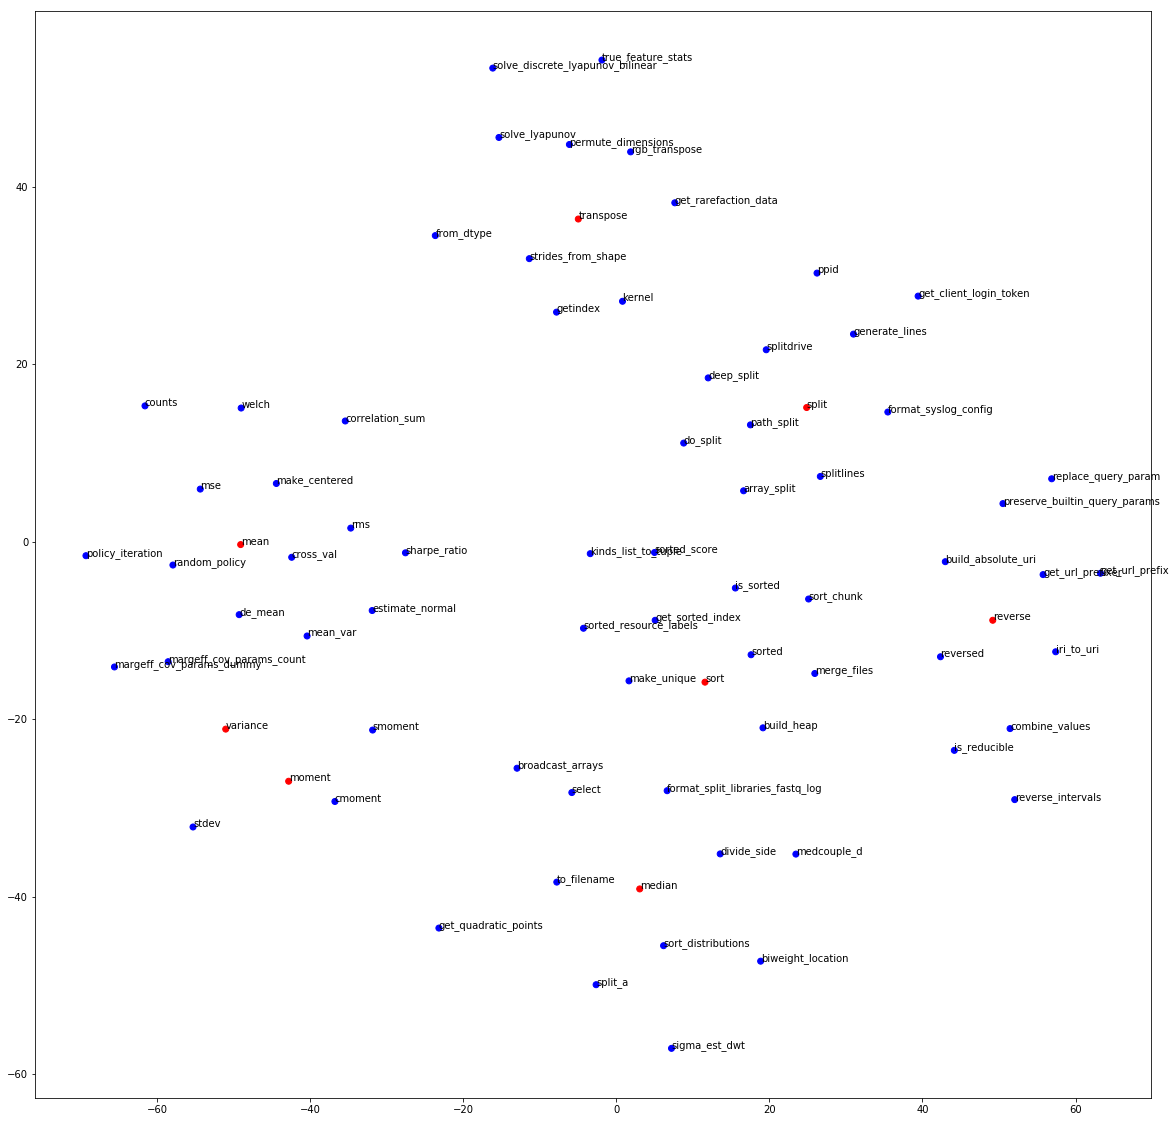

In [14]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 20))

colors = ['r' if x in interestWords else 'b' for x in labels]
plt.scatter(x_vals, y_vals, color = colors)

indices = list(range(len(labels)))
for i in indices:
    plt.annotate(labels[i], (x_vals[i], y_vals[i]))
plt.show()

# Load code2vec vectors

In [15]:
from gensim.models import KeyedVectors as word2vec
c2v_model = word2vec.load_word2vec_format('code2vec/models/targets.txt', binary=False)

In [16]:
interestWords = ['variance', 'mean', 'moment', 'transpose', 'split', 'sort', 'reverse', 'median']

num_dimensions = 2  # final num dimensions (2D, 3D, etc)
c2v_vectors = [] # positions in vector space
c2v_labels = [] # keep track of words to label our data again later
for word in tqdm(interestWords):
    c2v_vectors.append(c2v_model[word])
    c2v_labels.append(word)
    for s_word, sc in c2v_model.most_similar(word, topn=10):
        c2v_vectors.append(c2v_model[s_word])
        c2v_labels.append(s_word)
c2v_vectors = np.asarray(c2v_vectors)
c2v_labels = np.asarray(c2v_labels)

used = dict()
tmp_vectors = []
tmp_labels = []
for label, vect in zip(c2v_labels, c2v_vectors):
    if label not in used:
        used[label] = 1
        tmp_labels.append(label)
        tmp_vectors.append(vect)
c2v_labels = tmp_labels
c2v_vectors = tmp_vectors

100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 58.55it/s]


In [17]:
# reduce using t-SNE
c2v_tsne = TSNE(n_components=num_dimensions, random_state=0)
c2v_vectors = tsne.fit_transform(c2v_vectors)

c2v_x_vals = [v[0] for v in c2v_vectors]
c2v_y_vals = [v[1] for v in c2v_vectors]

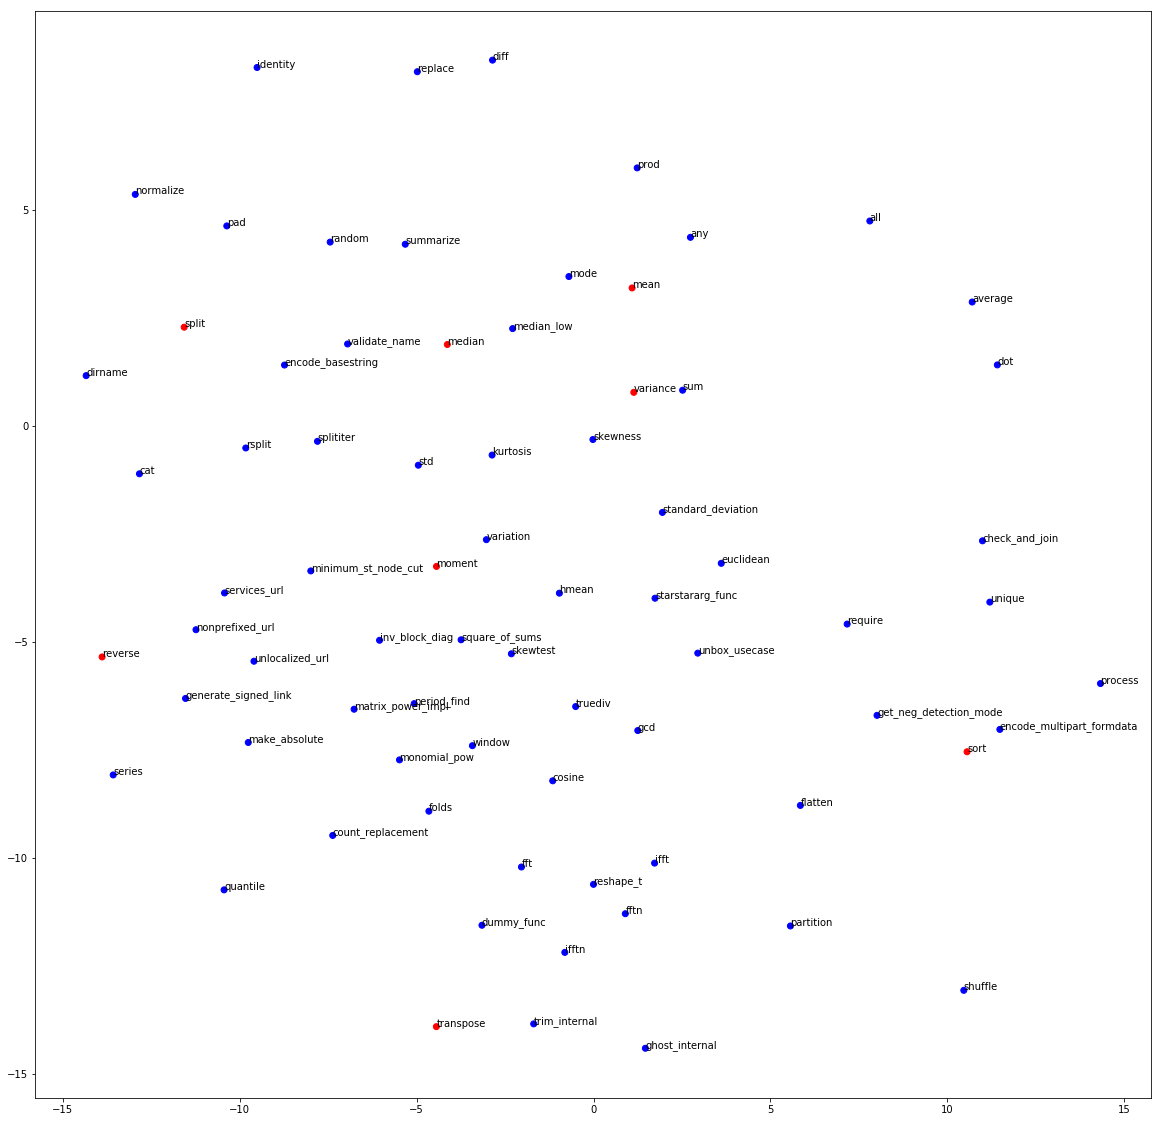

In [18]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 20))
colors = ['r' if x in interestWords else 'b' for x in c2v_labels]
plt.scatter(c2v_x_vals, c2v_y_vals, color=colors)

indices = list(range(len(c2v_labels)))
for i in indices:
    plt.annotate(c2v_labels[i], (c2v_x_vals[i], c2v_y_vals[i]))
plt.show()

In [19]:
a = "variance"
model.most_similar(a), c2v_model.most_similar(a)

C:\Users\kolpa\Anaconda3\envs\p3.6-tensorflow1.13\lib\site-packages\ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  


([('moment', 0.6614700555801392),
  ('cmoment', 0.628387451171875),
  ('de_mean', 0.6208703517913818),
  ('welch', 0.6058287024497986),
  ('margeff_cov_params_count', 0.600078821182251),
  ('cross_val', 0.5899167060852051),
  ('make_centered', 0.5845692157745361),
  ('random_policy', 0.5813606381416321),
  ('stdev', 0.5810993313789368),
  ('margeff_cov_params_dummy', 0.575221061706543)],
 [('skewness', 0.45580703020095825),
  ('mean', 0.4190789461135864),
  ('euclidean', 0.39425918459892273),
  ('mode', 0.38199782371520996),
  ('hmean', 0.3812142610549927),
  ('starstararg_func', 0.37281596660614014),
  ('standard_deviation', 0.3679535686969757),
  ('kurtosis', 0.3604142963886261),
  ('unbox_usecase', 0.3599628210067749),
  ('moment', 0.3591627776622772)])

# Similarity node2vec vs code2vec

In [19]:
def jacard_sim(a, b):
    a = set(a)
    b = set(b)
    return len(a & b) / len(a | b)

In [20]:
topn = 100
sims = []
n2v_words = []
err_words = []
for n2v_word in tqdm(model.wv.vocab):
    n2v_neighbours = np.array([x for x, sc in model.wv.most_similar(n2v_word, topn=topn)])
    try:
        c2v_neighbours = np.array([x for x, sc in c2v_model.most_similar(n2v_word, topn=topn)])
    except KeyError:
        err_words.append(n2v_word)
        continue
    sims.append(jacard_sim(n2v_neighbours, c2v_neighbours))
    n2v_words.append(n2v_word)
sims = np.array(sims)

  1%|▋                                                                            | 643/70796 [00:04<08:19, 140.34it/s]


KeyboardInterrupt: 

In [ ]:
err_words

In [93]:
sims.mean()

0.0034150310228898725

In [94]:
sims.std()

0.010247098954559192

In [98]:
tmp = [(x, y) for x, y in zip(sims, n2v_words)]
tmp = sorted(tmp, reverse=True)
sims = np.array([x for x, y in tmp])
n2v_words = np.array([y for x, y in tmp])

In [96]:
word = n2v_words[0]
a = [x for x, y in c2v_model.most_similar(word)]
b = [x for x, y in model.wv.most_similar(word)]
word, a, b

('delete_cache_cluster',
 ['delete_replication_group',
  'create_cache_parameter_group',
  'delete_cache_subnet_group',
  'project_absent',
  'mk_s_list',
  'describe_cache_clusters',
  'store_exception',
  'data_spider',
  'topic_rule_present',
  'get_default_hparams'],
 ['delete_resource',
  'delete_route_table',
  'delete_dhcp_options',
  'delete_subnet',
  'cache_id',
  'delete',
  'delete_internet_gateway',
  'delete_statuses',
  'delete_topic',
  'delete_profile'])

In [99]:
tmp

[(0.19760479041916168, 'list_floatingips'),
 (0.19047619047619047, 'list_ipsec_site_connections'),
 (0.1834319526627219, 'dmp_clear_denoms'),
 (0.17647058823529413, 'show_ikepolicy'),
 (0.17647058823529413, 'process_xml_element'),
 (0.17647058823529413, 'list_routers'),
 (0.17647058823529413, 'list_quotas'),
 (0.17647058823529413, 'list_firewalls'),
 (0.17647058823529413, 'dmp_inner_gcd'),
 (0.1695906432748538, 'list_security_group_rules'),
 (0.1695906432748538, 'dmp_gcd'),
 (0.1695906432748538, 'dmp_cancel'),
 (0.16279069767441862, 'list_firewall_rules'),
 (0.16279069767441862, 'keypair_list'),
 (0.15606936416184972, 'show_router'),
 (0.15606936416184972, 'parse_vnc'),
 (0.15606936416184972, 'list_ipsecpolicies'),
 (0.15606936416184972, 'list_agents'),
 (0.15606936416184972, 'dmp_ff_prs_gcd'),
 (0.15606936416184972, 'dmp_eval_in'),
 (0.15606936416184972, 'dmp_div'),
 (0.15606936416184972, 'dmp_convert'),
 (0.15606936416184972, 'delete_vpnservice'),
 (0.14942528735632185, 'primitive'),

In [95]:
sum(sims>0)

19577

In [22]:
model.most_similar('variance')

C:\Users\kolpa\Anaconda3\envs\p3.6-tensorflow1.13\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('moment', 0.6614700555801392),
 ('cmoment', 0.628387451171875),
 ('de_mean', 0.6208703517913818),
 ('welch', 0.6058287024497986),
 ('margeff_cov_params_count', 0.600078821182251),
 ('cross_val', 0.5899167060852051),
 ('make_centered', 0.5845692157745361),
 ('random_policy', 0.5813606381416321),
 ('stdev', 0.5810993313789368),
 ('margeff_cov_params_dummy', 0.575221061706543)]

In [ ]:
model.similar_by_word()

In [31]:
c2v_model.most_similar('mean')

[('prod', 0.43243950605392456),
 ('mode', 0.42214298248291016),
 ('variance', 0.4190789461135864),
 ('sum', 0.4037366509437561),
 ('hmean', 0.38929781317710876),
 ('all', 0.38652274012565613),
 ('std', 0.3847612738609314),
 ('skewness', 0.37193912267684937),
 ('median', 0.3581177592277527),
 ('any', 0.35745418071746826)]